In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load Kitti dataset

In [2]:
require 'paths'
require 'image'

relative = '../Datasets/Kitti/data_road/'
labels = torch.load(relative .. 'training/labels.t7')
images = torch.FloatTensor(289, 3, 270, 896)
-- labels = torch.ByteTensor(289, 270, 896)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'training/image_2/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    local img = image.load(relative .. 'training/image_2/' .. file)
    images[id]:copy(image.scale(img, 896, 270, 'bicubic'))
--     
--     local lbl = image.load(relative .. 'training/gt_image_2/' .. file:gsub('_', '_road_'))
--     labels[id]:copy(image.scale(lbl:sum(1), 896, 270, 'simple'))
end

-- labels[labels:eq(0)] = 1

mean = {}
std = {}

for channel = 1,3 do
    mean[channel] = images[{{}, channel, {}, {}}]:mean()
    images[{{}, channel, {}, {}}]:add(-mean[channel])
    
    std[channel] = images[{{}, channel, {}, {}}]:std()
    images[{{}, channel, {}, {}}]:div(std[channel])
end

collectgarbage()

### Render labels for displaying

In [3]:
function renderLabels(labels, img, blendCoeff)
    local LUT = {
        [0] = {0.0, 1.0, 0.0}, -- void
        [1] = {0.0, 0.0, 0.0}, -- no road
        [2] = {1.0, 0.0, 0.0}, -- road
    }
    
    local retval = torch.FloatTensor(3, labels:size(1), labels:size(2))
    for i = 1,labels:size(1) do
        for j = 1,labels:size(2) do
            for k, color in ipairs(LUT[labels[{i,j}]]) do
                retval[{k,i,j}] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = blendCoeff or 0.5
        retval:mul(labelsBlendCoeff)
        
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        img:mul(1 - labelsBlendCoeff)
        retval:add(img)
    end
    
    return retval
end

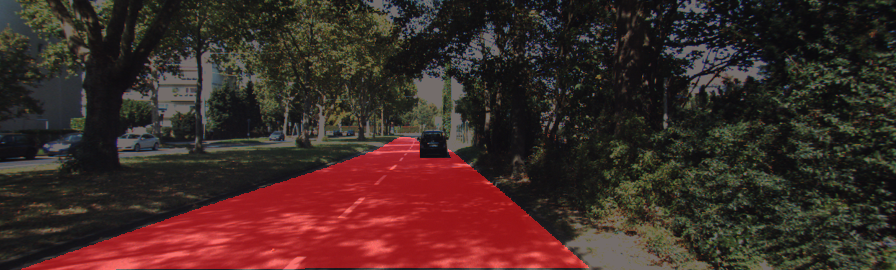

In [4]:
-- example blending
local k = 10
itorch.image(renderLabels(labels[k], images[k]))
-- itorch.image(comparePredictions(images[k], labels[k], predict(net, images[k])))

In [5]:
require 'nn'

function jitterScale(img, labelsMat)
    local h, w = img:size(2), img:size(3)
    
--     local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local scaleDiffFactor = -math.random() * 0.05
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), w, h, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, h, w)), w, h, 'simple')

    return imgScaled, labelsMatScaled:view(h, w)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = imgFlipped or img --image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = labelsMatFlipped or labelsMat
        --image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [6]:
CUDA = true

In [7]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'IntegralSmartNorm'

In [8]:
if CUDA then
    require 'cunn'
end

net = torch.load('Kitti 3layers no1px/net.t7')
losses = torch.load('Kitti 3layers no1px/loss-history.t7')

ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].maxX = 210
    ints[i].maxY = 540
end

In [39]:
local h, w = 270,896

net = nn.Sequential()

convPlusInt = nn.Concat(1)
convPlusInt:add(IntegralSmartNorm(20, h, w))
convPlusInt:add(nn.SpatialConvolution(3, 18, 5,5, 1,1, 2,2))
net:add(convPlusInt) -- 3 -> 78

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolutionMM(78, 8, 1,1,1,1)) -- 78 -> 8

convPlusInt2 = nn.Concat(1)
convPlusInt2:add(IntegralSmartNorm(12, h, w))
convPlusInt2:add(nn.SpatialConvolution(8, 12, 3,3, 1,1, 1,1))
net:add(convPlusInt2) -- 8 -> 108

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolution(108, 10, 1,1,1,1)) -- 108 -> 10

convPlusInt3 = nn.Concat(1)
convPlusInt3:add(IntegralSmartNorm(10, h, w))
convPlusInt3:add(nn.SpatialConvolution(10, 12, 3,3, 1,1, 1,1))
net:add(convPlusInt3) -- 10 -> 112

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolution(112, 2, 1,1,1,1)) -- 112 -> 2

net:add(nn.Reshape(2, h*w))
net:add(nn.Transpose({2, 1}))

ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].maxX = 210
    ints[i].maxY = 540
end

if CUDA then
    require 'cunn'
    net:cuda()
end

collectgarbage()

In [9]:
params, gradParams = net:parameters()

In [10]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels)):type(net:type())

In [11]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 1e-3
    if i <= 4 or (i >= 9 and i <= 12) or (i >= 17 and i <= 20) then
        lr = lr * 600
    end
    
    optimStates[i] = {
        learningRate = lr,
        learningRateDecay = 0.99955
    }
end

In [12]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

In [37]:
local filenames = {}
for file in paths.files(relative .. 'testing/image_2/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

local avgTime = 0
local numRuns = 0

local i = 1
while i <= #filenames do
    local img = image.scale(image.load(relative .. 'testing/image_2/' .. filenames[i]), 896, 270, 'bicubic')
    
    local imgForNet = img:cuda()
    for channel = 1,3 do
        imgForNet[channel]:add(-mean[channel])
        imgForNet[channel]:div(std[channel])
    end
    
    timer = torch.Timer()
    local prediction = predict(net, imgForNet)
    avgTime = avgTime + timer:time().real
    numRuns = numRuns + 1
    
    local output = torch.ones(3, img:size(2)*2 + 4, img:size(3))
    
    output[{{}, {1, img:size(2)}, {}}]:copy(img)
    output[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(prediction, img))
    
    image.save(outputDir .. 'Images (test)/' .. '_' .. filenames[i], output)
    
    i = i + 6
end

collectgarbage()
print('Average inference time: ' .. (avgTime / numRuns * 1e3) .. ' ms')

Average inference time: 192.93387568727 ms	


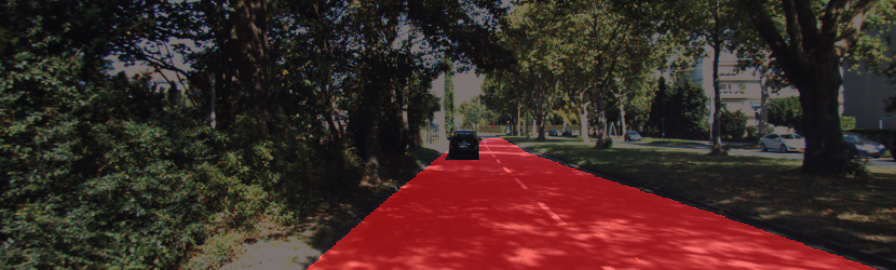

In [50]:
k = 10
img, lab = jitter(images[k], labels[k], torch.random() % 2 == 0)
itorch.image(renderLabels(lab, img))

In [14]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(3)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.axis{1, #losses, 0.05, 0.7}
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [15]:
outputDir = 'Kitti 3layers no1px/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [16]:
losses = {}

In [17]:
function predict(net, example)
    local pred = net:forward(example:type(net:type()))
    return select(2, pred:view(example:size(2), example:size(3), 2):max(3)):squeeze():float()
end

function comparePredictions(img, labels, prediction, omitOriginal)
    img = img:clone():float()
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2)*2 + 4, img:size(3))

        retval[{{}, {1, img:size(2)}, {}}]:copy(renderLabels(labels, img))
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2)*3 + 4, img:size(3))
        retval[{{}, {1, img:size(2)}, {}}]:copy(img)
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(labels, img))
        retval[{{}, {img:size(2)*2+5, retval:size(2)}, {}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

In [18]:
evaluationIdx = {
    1, 14, 27, 40, 53, 66, 79, 92, 105, 118, 131, 144, 157, 
    170, 183, 196, 209, 222, 235, 248, 261, 274, 287
}

table.sort(evaluationIdx)

In [19]:
function evaluate(net, images, labels, indices, outPath)
    local losses = {}
    local avgLoss = 0
    
    for k,idx in ipairs(indices) do
        local input = images[idx]:type(net:type())
        local outputs = net:forward(input)
        local target = labels[idx]:clone()
        
        if outPath then
            image.savePNG(
                outPath .. string.format('/%03d.png', idx), 
                comparePredictions(input, target, 
                    select(2, outputs:view(target:size(1), target:size(2), 2):max(3)):squeeze():float()))
        end
        
        target = target:view(target:nElement())

--         for i = 1,target:nElement() do
--             if target[i] == 0 then
--                 target[i] = 3
--                 outputs[i]:zero()
--                 outputs[{i,3}] = 1e4
--             end
--         end

        target = target:type(criterion.lsm:type())

        local loss = criterion:forward(outputs, target)
        losses[k] = loss
        avgLoss = avgLoss + loss
    end
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    return avgLoss, losses
end

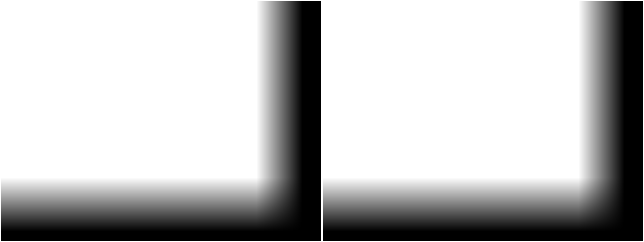

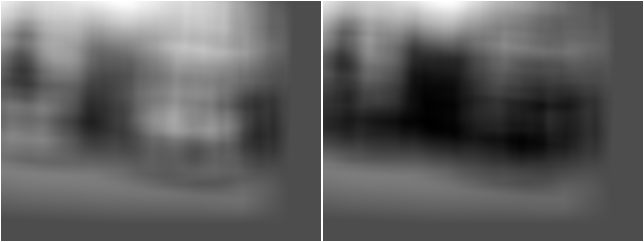

-0.0009765625	0.0009765625	


-976.5625	976.5625	


In [69]:
local k = 6
local int = net:get(1):get(1)

itorch.image{int.outputOnes[k], int.outputOnes[k+24]}
itorch.image{int.outputNonNorm[k], int.outputNonNorm[k+24]}
print(int.outputNonNorm[k][{{1,10}, {310,320}}]:min(), int.outputNonNorm[k+24][{{1,10}, {310,320}}]:max())

itorch.image{int.output[k][{{1,10}, {310,320}}], int.output[k+24][{{1,10}, {310,320}}]}
print(int.output[k][{{1,10}, {310,320}}]:min(), int.output[k+24][{{1,10}, {310,320}}]:max())
-- print(int.outputOnes[k]:eq(1e-6):sum())

In [ ]:
batchSize = 6
shuffleEvery = math.ceil(images:size(1) / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 6 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 24 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 20 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,images:size(1) do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,145 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(net:get(1):get(1))
    windowDebugger_2:add(net:get(4):get(1))
    windowDebugger_3:add(net:get(7):get(1))
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]], 
                torch.random() % 2 == 0)
            
            target = target:view(target:nElement())

            input = input:type(net:type())
            local outputs = net:forward(input)

--             for i = 1,target:nElement() do
--                 if target[i] == 0 then
--                     target[i] = 3
--                     outputs[i]:zero()
--                     outputs[{i,3}] = 1e4
--                 end
--             end
            
            target = target:type(net:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % labels:size(1) + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end
        
        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        losses[#losses+1] = 
            evaluate(net, images, labels, evaluationIdx,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/'))
        -- losses[#losses+1] = avgLoss / outputFreq
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
        windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
    end
    
    if iter % 4 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (avgLoss / 4 or -1) .. ', ' .. os.date()
        )
        avgLoss = 0
    end
end

Epoch 0	


In [349]:
evaluate(net, images, labels, evaluationIdx, outputDir .. 'Images/')

0.95531758357739	{
  1 : 0.64767742156982
  2 : 0.6600529551506
  3 : 0.69543921947479
  4 : 1.019557595253
  5 : 0.99425214529037
  6 : 0.80037921667099
  7 : 1.1323467493057
  8 : 0.9406573176384
  9 : 1.150452375412
  10 : 0.82327663898468
  11 : 0.5520516037941
  12 : 1.1003781557083
  13 : 1.0453722476959
  14 : 1.3467782735825
  15 : 1.0229215621948
  16 : 0.81896859407425
  17 : 0.7320744395256
  18 : 0.76737630367279
  19 : 1.5493805408478
  20 : 1.3646283149719
  21 : 0.89476817846298
  22 : 1.4090570211411
  23 : 1.0427916049957
  24 : 1.3882250785828
  25 : 1.2055470943451
  26 : 0.73753535747528
  27 : 0.91631376743317
  28 : 0.51084238290787
  29 : 0.43510776758194
}
